# graphVIPER Tutorial: Processing Set

In [1]:
import os

from importlib.metadata import version

try:
    import graphviper

    print("graphVIPER version", version("graphviper"), "already installed.")
except ImportError as e:
    print(e)
    print("Installing graphVIPER")

    os.system("pip install graphviper")

    import graphviper

    print("graphVIPER version", version("graphviper"), " installed.")

graphVIPER version 0.0.1 already installed.


## Download and convert dataset

In [2]:
from xradio.data.datasets import download

download(file="Antennae_North.cal.lsrk.split.ms", source="dropbox")

from xradio.vis.convert_msv2_to_processing_set import convert_msv2_to_processing_set

partition_scheme = "ddi_intent_field"
main_chunksize = {"frequency": 3}
in_file = "Antennae_North.cal.lsrk.split.ms"
out_file = "Antennae_North.cal.lsrk.split.vis.zarr"
convert_msv2_to_processing_set(
    in_file=in_file,
    out_file=out_file,
    partition_scheme=partition_scheme,
    parallel=False,
    overwrite=True,
    main_chunksize=main_chunksize,
)

File exists.


In [3]:
from xradio.data.datasets import download
from graphviper.graph_tools import map
import dask

ps_name = "Antennae_North.cal.lsrk.split.vis.zarr"
download(file=ps_name, source="dropbox")

File exists.


## Setup Dask Cluster
To simplify things we are going to start of by just using a single thread (everything will run in serial).

In [4]:
# from graphviper.dask import local_client

# viper_client = local_client(cores=2, memory_limit="4GB")
# viper_client

import dask
dask.config.set(scheduler="synchronous")

## Inscpect Processing Set

The read_processing_set is a lazy function, so no data is loaded into memory, only metadata.

In [5]:
import pandas as pd

pd.options.display.max_colwidth = 100
ps_name = "Antennae_North.cal.lsrk.split.vis.zarr"

from xradio.vis.read_processing_set import read_processing_set

# fields = ["NGC4038 - Antennae North"]
intents = ["OBSERVE_TARGET#ON_SOURCE"]
fields = None
ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
    fields=fields,
)
display(ps.summary())

,name,ddi,intent,field_id,field_name,start_frequency,end_frequency
0,Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_1,0,OBSERVE_TARGET#ON_SOURCE,1,NGC4038 - Antennae North,3.439281e+11,3.440067e+11
1,Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_0,0,OBSERVE_TARGET#ON_SOURCE,0,NGC4038 - Antennae North,3.439281e+11,3.440067e+11
2,Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2,0,OBSERVE_TARGET#ON_SOURCE,2,NGC4038 - Antennae North,3.439281e+11,3.440067e+11


## Inspect a single ms_v4

In [6]:
ms_xds = ps.get(1)
ms_xds

<xarray.Dataset>
Dimensions:                     (time: 45, baseline_id: 64, frequency: 8,
                                 polarization: 2, uvw_label: 3)
Coordinates:
    baseline_antenna1_id        (baseline_id) int64 dask.array<chunksize=(64,), meta=np.ndarray>
    baseline_antenna2_id        (baseline_id) int64 dask.array<chunksize=(64,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 0 1 2 3 4 ... 59 60 61 62 63
  * frequency                   (frequency) float64 3.439e+11 ... 3.44e+11
  * polarization                (polarization) <U2 'XX' 'YY'
  * time                        (time) float64 1.307e+09 1.307e+09 ... 1.307e+09
  * uvw_label                   (uvw_label) <U1 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 dask.array<chunksize=(45, 64), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool dask.array<chunksize=(45, 64, 3, 2), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 dask.array<chunksize=(45, 64), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 dask.array<chunksize=(45, 64, 3), meta=np.ndarray>
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 dask.array<chunksize=(45, 64, 3, 2), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 dask.array<chunksize=(45, 64, 3, 2), meta=np.ndarray>
Attributes:
    data_groups:  {'base': {'flag': 'FLAG', 'uvw': 'UVW', 'visibility': 'VISI...
    ddi:          0
    field_info:   {'code': 'none', 'delay_direction': {'attrs': {'frame': 'FK...
    intent:       OBSERVE_TARGET#ON_SOURCE
    antenna_xds:  <xarray.Dataset>\nDimensions:        (antenna_id: 15, coord...

## Frequency Map Reduce
The parallel coordinates determine the parallelism of the map graph. Each chunk in the parallel coordinates represents a selection criterion used for the subselected processing set that is sent to a node. 

The parallel_coords is a dictionary where each key represents a dimension coordinate that appears in your data. For ms_v4, the options would be time, baseline/antenna, frequency, and polarization. The _make_parallel_coord function will convert any XRADIO measures into a parallel coordinate. In addition, convenient functions have been created: _make_time_coord and _make_frequency_coord that will create numpy arrays.

### Create Parallel Coordinates

In [7]:
from graphviper.graph_tools.utils import make_parallel_coord
from graphviper.utils.display import dict_to_html
from IPython.display import HTML, display

parallel_coords = {}
n_chunks = 3
parallel_coords["frequency"] = make_parallel_coord(
    coord=ms_xds.frequency, n_chunks=n_chunks
)
display(HTML(dict_to_html(parallel_coords["frequency"])))

In [8]:
from graphviper.graph_tools import make_frequency_coord

n_chunks = 3

coord = make_frequency_coord(
    freq_start=343928096685.9587,
    freq_delta=11231488.981445312,
    n_channels=8,
    velocity_frame="lsrk",
)
parallel_coords["frequency"] = make_parallel_coord(
    coord=ms_xds.frequency, n_chunks=n_chunks
)
display(HTML(dict_to_html(parallel_coords["frequency"])))

### Create a chunk function and map graph

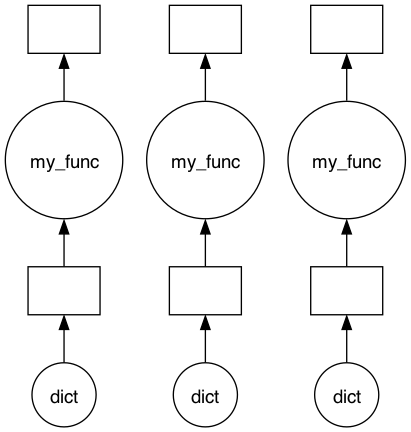

In [9]:
from graphviper.graph_tools import map
import dask
from graphviper.utils.display import dict_to_html
from IPython.display import display, HTML


def my_func(input_parms):
    display(HTML(dict_to_html(input_parms)))

    print("*" * 30)
    return input_parms["test_input"]


# ['test_input', 'input_data_store', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']
input_parms = {}
input_parms["test_input"] = 42

ps_name = "Antennae_North.cal.lsrk.split.vis.zarr"
sel_parms = {}
sel_parms["fields"] = ["NGC4038 - Antennae North"]
sel_parms["intents"] = ["OBSERVE_TARGET#ON_SOURCE"]
graph = map(
    input_data_store=ps_name,
    input_data_type="processing_set",
    ps_sel_parms=sel_parms,
    parallel_coords=parallel_coords,
    node_task=my_func,
    input_parms=input_parms,
    client=None,
)

dask.visualize(graph, filename="map_graph")

In [10]:
graph

([Delayed('my_func-0a320a00-94cb-424f-8719-45ee1f97601f'),
  Delayed('my_func-faecbdc3-329a-4d37-8580-d0ab2bdb217e'),
  Delayed('my_func-026bab5d-caf3-418f-a8da-0e4189745a62')],
 None)

### Run Map Graph

In [11]:
dask.compute(graph)

******************************


******************************


******************************


(([42, 42, 42], None),)

In [12]:
graph

([Delayed('my_func-0a320a00-94cb-424f-8719-45ee1f97601f'),
  Delayed('my_func-faecbdc3-329a-4d37-8580-d0ab2bdb217e'),
  Delayed('my_func-026bab5d-caf3-418f-a8da-0e4189745a62')],
 None)

### Reduce Graph

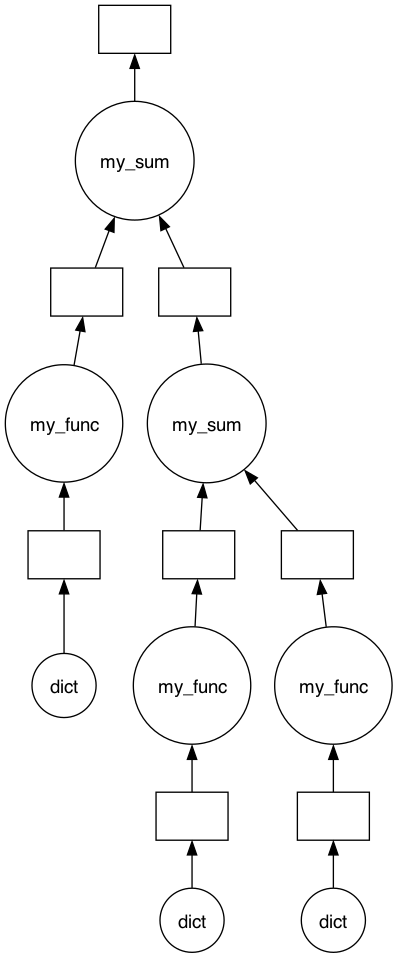

In [13]:
from graphviper.graph_tools import reduce
import numpy as np


def my_sum(graph_inputs, input_parms):
    print(graph_inputs)
    return np.sum(graph_inputs) + input_parms["test_input"]


input_parms = {}
input_parms["test_input"] = 5
graph_reduce = reduce(
    graph, my_sum, input_parms, mode="tree"
)  # mode "tree","single_node"
dask.visualize(graph_reduce)

### Run Map Reduce Graph

In [14]:
dask.compute(graph_reduce)

******************************


******************************
[42, 42]


******************************
[89, 42]


([[136], None],)

## Overlapping Frequency Map Reduce

### Create Parallel Coordinates

In [15]:
from graphviper.graph_tools import make_parallel_coord
import dask

dask.config.set(scheduler="synchronous")

from xradio.vis.read_processing_set import read_processing_set
from graphviper.utils.display import dict_to_html
from IPython.display import HTML, display

intents = ["OBSERVE_TARGET#ON_SOURCE"]
ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)
ms_xds = ps.get(1)

from astroviper._concurrency._graph_tools import _make_frequency_coord

n_chunks = 3

parallel_coords = {}
freq_coord = ms_xds.frequency.to_dict()
freq_coord["data_chunks"] = {
    0: freq_coord["data"][0:4],
    1: freq_coord["data"][3:7],
    2: freq_coord["data"][4:8],
}
parallel_coords["frequency"] = freq_coord
display(HTML(dict_to_html(parallel_coords["frequency"])))

### Map Graph

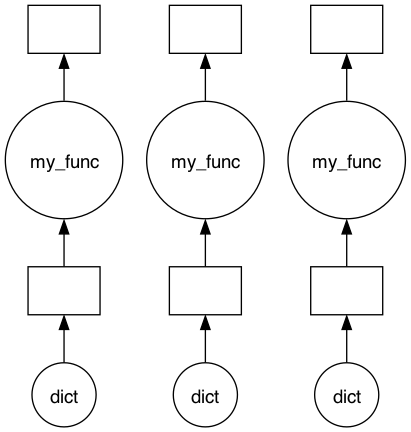

In [16]:
from graphviper.graph_tools import map
import dask
from graphviper.utils.display import dict_to_html
from IPython.display import display, HTML


def my_func(input_parms):
    display(HTML(dict_to_html(input_parms)))

    print("*" * 30)
    return input_parms["test_input"]


# ['test_input', 'input_data_store', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']
input_parms = {}
input_parms["test_input"] = 42

ps_name = "Antennae_North.cal.lsrk.split.vis.zarr"
sel_parms = {}
sel_parms["fields"] = ["NGC4038 - Antennae North"]
sel_parms["intents"] = ["OBSERVE_TARGET#ON_SOURCE"]
graph = map(
    input_data_store=ps_name,
    input_data_type="processing_set",
    ps_sel_parms=sel_parms,
    parallel_coords=parallel_coords,
    node_task=my_func,
    input_parms=input_parms,
    client=None,
)

dask.visualize(graph, filename="map_graph")

### Run Map Graph

In [17]:
dask.compute(graph)

******************************


******************************


******************************


(([42, 42, 42], None),)

## Baseline and Frequency Map Reduce

### Create Parallel Coordinates

In [18]:
from graphviper.graph_tools import make_parallel_coord
import dask

dask.config.set(scheduler="synchronous")

from xradio.vis.read_processing_set import read_processing_set
from graphviper.utils.display import dict_to_html
from IPython.display import HTML, display

intents = ["OBSERVE_TARGET#ON_SOURCE"]
ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)
ms_xds = ps.get(1)

parallel_coords = {}

import xarray as xr
import numpy as np

n_chunks = 4
parallel_coords["baseline_id"] = make_parallel_coord(
    coord=ms_xds.baseline_id, n_chunks=n_chunks
)

n_chunks = 3
parallel_coords["frequency"] = make_parallel_coord(
    coord=ms_xds.frequency, n_chunks=n_chunks
)

display(HTML(dict_to_html(parallel_coords)))

### Map Graph

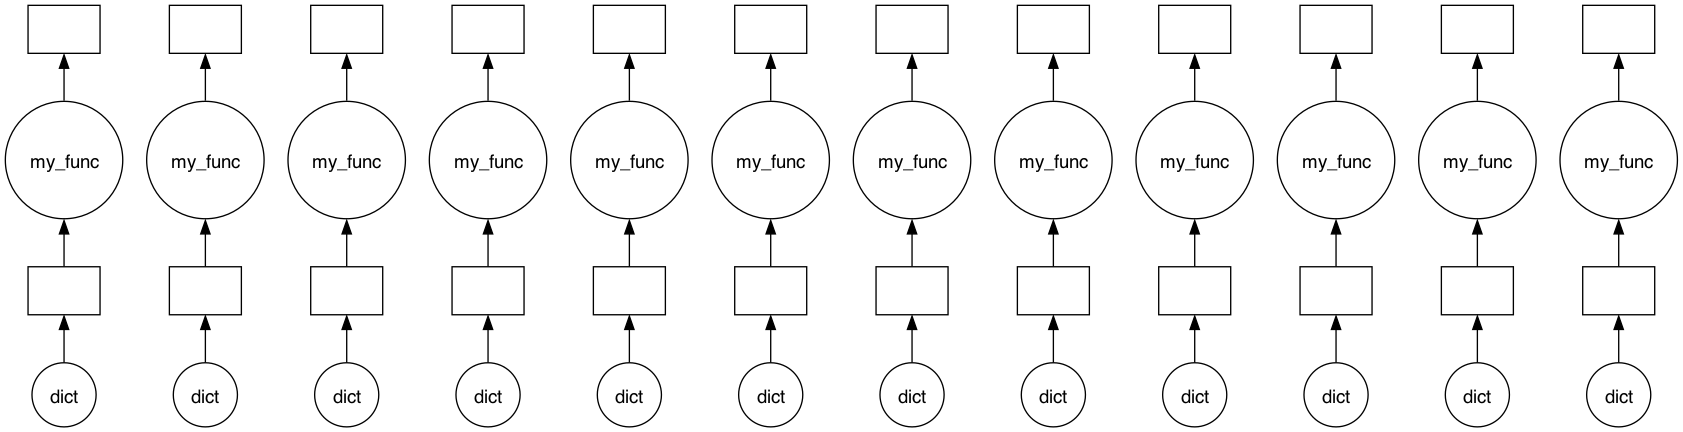

In [19]:
from graphviper.graph_tools import map
import dask
from graphviper.utils.display import dict_to_html
from IPython.display import display, HTML


def my_func(input_parms):
    display(HTML(dict_to_html(input_parms)))

    print("*" * 30)
    return input_parms["test_input"]


# ['test_input', 'input_data_store', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']
input_parms = {}
input_parms["test_input"] = 42

ps_name = "Antennae_North.cal.lsrk.split.vis.zarr"
sel_parms = {}
sel_parms["fields"] = ["NGC4038 - Antennae North"]
sel_parms["intents"] = ["OBSERVE_TARGET#ON_SOURCE"]
graph = map(
    input_data_store=ps_name,
    input_data_type="processing_set",
    ps_sel_parms=sel_parms,
    parallel_coords=parallel_coords,
    node_task=my_func,
    input_parms=input_parms,
    client=None,
)

dask.visualize(graph, filename="map_graph")

### Run Map Graph

In [20]:
dask.compute(graph)

******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


(([42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42], None),)

## Time Map Reduce

### Create Parallel Coordinates

In [21]:
from graphviper.graph_tools import make_parallel_coord
import dask

dask.config.set(scheduler="synchronous")

from xradio.vis.read_processing_set import read_processing_set
from graphviper.utils.display import dict_to_html
from IPython.display import HTML, display

intents = ["OBSERVE_TARGET#ON_SOURCE"]
ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)
ms_xds = ps.get(1)

parallel_coords = {}

import xarray as xr
import numpy as np

t0, t1, t2 = (ps.get(1).time, ps.get(0).time, ps.get(2).time)
time_coord = xr.concat([t0, t1, t2], dim="time").sortby("time").to_dict()
n_chunks = 4
parallel_coords["time"] = make_parallel_coord(coord=time_coord, n_chunks=n_chunks)
display(HTML(dict_to_html(parallel_coords["time"])))

### Map Graph

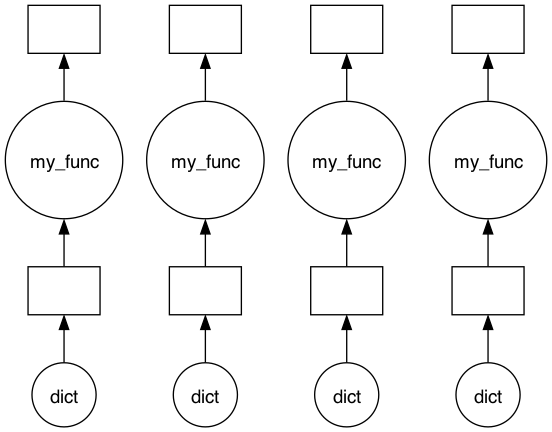

In [22]:
from graphviper.graph_tools import map
import dask
from graphviper.utils.display import dict_to_html
from IPython.display import display, HTML


def my_func(input_parms):
    display(HTML(dict_to_html(input_parms)))

    print("*" * 30)
    return input_parms["test_input"]


# ['test_input', 'input_data_store', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']
input_parms = {}
input_parms["test_input"] = 42

ps_name = "Antennae_North.cal.lsrk.split.vis.zarr"
sel_parms = {}
sel_parms["fields"] = ["NGC4038 - Antennae North"]
sel_parms["intents"] = ["OBSERVE_TARGET#ON_SOURCE"]
graph = map(
    input_data_store=ps_name,
    input_data_type="processing_set",
    ps_sel_parms=sel_parms,
    parallel_coords=parallel_coords,
    node_task=my_func,
    input_parms=input_parms,
    client=None,
)

dask.visualize(graph, filename="map_graph")

### Run Map Graph

In [23]:
dask.compute(graph)

******************************


******************************


******************************


******************************


(([42, 42, 42, 42], None),)